# Traffic camera filtering + row-wise traffic totals

This notebook:
1. Loads `tf-ft-eng.csv`
2. Filters to a specified set of `camera_road` values
3. Computes per-row:
   - `traffic_sum`: sum across all daily traffic columns (`xYYYY_MM_DD`)
   - `na_count`: number of missing values across those daily traffic columns

Optional: aggregates totals by `camera_road`.

In [1]:
import pandas as pd
import numpy as np
import re

# Update this path if your CSV is elsewhere
CSV_PATH = "tf-ft-eng.csv"

df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), "| Cols:", df.shape[1])
df.head()

Rows: 3609 | Cols: 1373


,WKT,CSDUID,traffic_camera,traffic_source,camera_road,x2022_02_02,x2022_02_03,x2022_02_04,x2022_02_05,x2022_02_06,...,x2025_10_22,x2025_10_23,x2025_10_24,x2025_10_25,x2025_10_26,x2025_10_27,x2025_10_28,x2025_10_29,x2025_10_30,x2025_10_31
0,POINT (-115.246 51.0405),4815015.0,001-02,Alberta,HWY 1,NaN,NaN,NaN,NaN,NaN,...,7.0,35.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,192.0
1,POINT (-114.492 51.0873),4806014.0,001-06,Alberta,HWY 1,NaN,NaN,NaN,NaN,NaN,...,11.0,16.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,288.0
2,POINT (-113.714 51.0381),4806014.0,001-10,Alberta,HWY 1,NaN,NaN,NaN,NaN,NaN,...,18.0,15.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,96.0
3,POINT (-112.784 50.8339),4805012.0,001-14,Alberta,HWY 1,NaN,NaN,NaN,NaN,NaN,...,7.0,8.0,17.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-112.475 50.8337),4802031.0,001-16,Alberta,HWY 1,NaN,NaN,NaN,NaN,NaN,...,32.0,28.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# # Roads to keep (duplicates are OK)
# roads_keep = [
#     "FRONT ST W / JOHN ST / PRIVATE ACCESS",
#     "KENNEDY RD / ELLESMERE RD",
#     "KENNEDY RD / 401 C E KENNEDY RD RAMP / WILLIAM KITCHEN RD",
#     "SHEPPARD AVE E / KENNEDY RD",
#     "LAWRENCE AVE E / KENNEDY RD",
#     "STEELES AVE E / KENNEDY RD",
#     "DUFFERIN ST / BLOOR ST W",
#     "DUFFERIN ST / BLOOR ST W",
#     "EGLINTON AVE W / DUFFERIN ST",
#     "DUFFERIN ST / FINCH AVE W",
#     "STEELES AVE W / DUFFERIN ST",
#     "KING ST W / DUFFERIN ST",
#     "QUEEN ST W / DUFFERIN ST",
#     "QUEEN ST W / DUFFERIN ST",
#     "WILSON AVE / DUFFERIN ST",
#     "COLLEGE ST / DUFFERIN ST",
#     "DUFFERIN ST / SASKATCHEWAN RD / BRITISH COLUMBIA RD",
#     "DUFFERIN ST / DUNDAS ST W",
#     "DUFFERIN ST / LIBERTY ST / PRIVATE ACCESS",
#     "F G GARDINER XY E / DUFFERIN ST",
# ]

roads_keep = ["LAWRENCE AVE E / KENNEDY RD",                              # East
              "STEELES AVE W / DUFFERIN ST",                              # North
              "FRONT ST W / JOHN ST / PRIVATE ACCESS",                    # Downtown
              "ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE",   # West (125 resources road)
            #   "HWY-7",
            #   "HWY 407"
              ]

# Normalize: strip whitespace and keep unique
roads_keep = sorted(set(r.strip() for r in roads_keep))
len(roads_keep), roads_keep[:3]

(4,
 ['FRONT ST W / JOHN ST / PRIVATE ACCESS',
  'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE',
  'LAWRENCE AVE E / KENNEDY RD'])

In [3]:
# Identify the daily traffic columns of the form xYYYY_MM_DD
date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
traffic_cols = [c for c in df.columns if date_col_pattern.match(str(c))]

print("Daily traffic columns found:", len(traffic_cols))
print("First 10:", traffic_cols[:10])

Daily traffic columns found: 1368
First 10: ['x2022_02_02', 'x2022_02_03', 'x2022_02_04', 'x2022_02_05', 'x2022_02_06', 'x2022_02_07', 'x2022_02_08', 'x2022_02_09', 'x2022_02_10', 'x2022_02_11']


In [4]:
# Filter to selected roads
if "camera_road" not in df.columns:
    raise KeyError("Expected a 'camera_road' column but it was not found.")

df_filt = df[df["camera_road"].astype(str).str.strip().isin(roads_keep)].copy()
print("Filtered rows:", len(df_filt))

# Per-row traffic sum (ignores NA) and NA count across daily columns
df_filt["traffic_sum"] = df_filt[traffic_cols].sum(axis=1, skipna=True)
df_filt["na_count"] = df_filt[traffic_cols].isna().sum(axis=1)

# First and last date where data exists for the row (based on daily columns xYYYY_MM_DD)
# Returns NaT when all daily values are missing for a row
def _first_last_dates(row):
    non_na = row.dropna()
    if non_na.empty:
        return pd.NaT, pd.NaT
    first_col = non_na.index[0].lstrip('x')
    last_col = non_na.index[-1].lstrip('x')
    return pd.to_datetime(first_col, format='%Y_%m_%d'), pd.to_datetime(last_col, format='%Y_%m_%d')

first_last = df_filt[traffic_cols].apply(_first_last_dates, axis=1, result_type='expand')
df_filt['first_date'] = first_last[0]
df_filt['last_date'] = first_last[1]

# Quick check
df_filt[["camera_road", "traffic_sum", "na_count", "first_date", "last_date"]].head(10)

Filtered rows: 4


,camera_road,traffic_sum,na_count,first_date,last_date
1412,FRONT ST W / JOHN ST / PRIVATE ACCESS,466599.0,210,2022-02-03,2025-10-31
1520,STEELES AVE W / DUFFERIN ST,542057.0,256,2022-02-03,2025-10-31
1574,ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...,224150.0,224,2022-02-03,2025-10-31
1590,LAWRENCE AVE E / KENNEDY RD,516275.0,482,2022-05-26,2025-10-31


In [5]:
# Optional: aggregate totals by road (useful if there are multiple rows per road)
# - total_traffic_sum: sum of row traffic sums
# - total_na: total NA count across rows
# - n_rows: number of rows for that road

by_road = (
    df_filt.groupby("camera_road", as_index=False)
    .agg(
        total_traffic_sum=("traffic_sum", "sum"),
        total_na=("na_count", "sum"),
        n_rows=("camera_road", "size"),
    )
    .sort_values("total_traffic_sum", ascending=False)
)

by_road

,camera_road,total_traffic_sum,total_na,n_rows
3,STEELES AVE W / DUFFERIN ST,542057.0,256,1
2,LAWRENCE AVE E / KENNEDY RD,516275.0,482,1
0,FRONT ST W / JOHN ST / PRIVATE ACCESS,466599.0,210,1
1,ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...,224150.0,224,1


In [6]:
# Sorting by total traffic sum
by_road = by_road.sort_values("total_traffic_sum", ascending=False)
by_road

,camera_road,total_traffic_sum,total_na,n_rows
3,STEELES AVE W / DUFFERIN ST,542057.0,256,1
2,LAWRENCE AVE E / KENNEDY RD,516275.0,482,1
0,FRONT ST W / JOHN ST / PRIVATE ACCESS,466599.0,210,1
1,ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALL...,224150.0,224,1


In [7]:
# Optional: save outputs
df_filt.to_csv("filtered_roads_with_sums.csv", index=False)
by_road.to_csv("summary_by_road.csv", index=False)
print("Saved: filtered_roads_with_sums.csv, summary_by_road.csv")

Saved: filtered_roads_with_sums.csv, summary_by_road.csv


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare data for plotting: transform from wide to long format
# We'll melt the traffic columns to create a time series

plot_data = []

for idx, row in df_filt.iterrows():
    camera_road = row['camera_road']
    # Extract traffic values for each date
    for col in traffic_cols:
        traffic_value = row[col]
        if pd.notna(traffic_value):  # Only include non-NA values
            # Parse date from column name (remove 'x' prefix and convert underscores)
            date_str = col[1:]  # Remove 'x'
            date = pd.to_datetime(date_str, format='%Y_%m_%d')
            plot_data.append({
                'date': date,
                'camera_road': camera_road,
                'traffic': traffic_value
            })

# Create DataFrame for plotting
df_plot = pd.DataFrame(plot_data)
print(f"Total data points for plotting: {len(df_plot)}")
df_plot.head()

Total data points for plotting: 4300


,date,camera_road,traffic
0,2022-02-03,FRONT ST W / JOHN ST / PRIVATE ACCESS,320.0
1,2022-02-04,FRONT ST W / JOHN ST / PRIVATE ACCESS,269.0
2,2022-02-05,FRONT ST W / JOHN ST / PRIVATE ACCESS,161.0
3,2022-02-06,FRONT ST W / JOHN ST / PRIVATE ACCESS,98.0
4,2022-02-07,FRONT ST W / JOHN ST / PRIVATE ACCESS,151.0


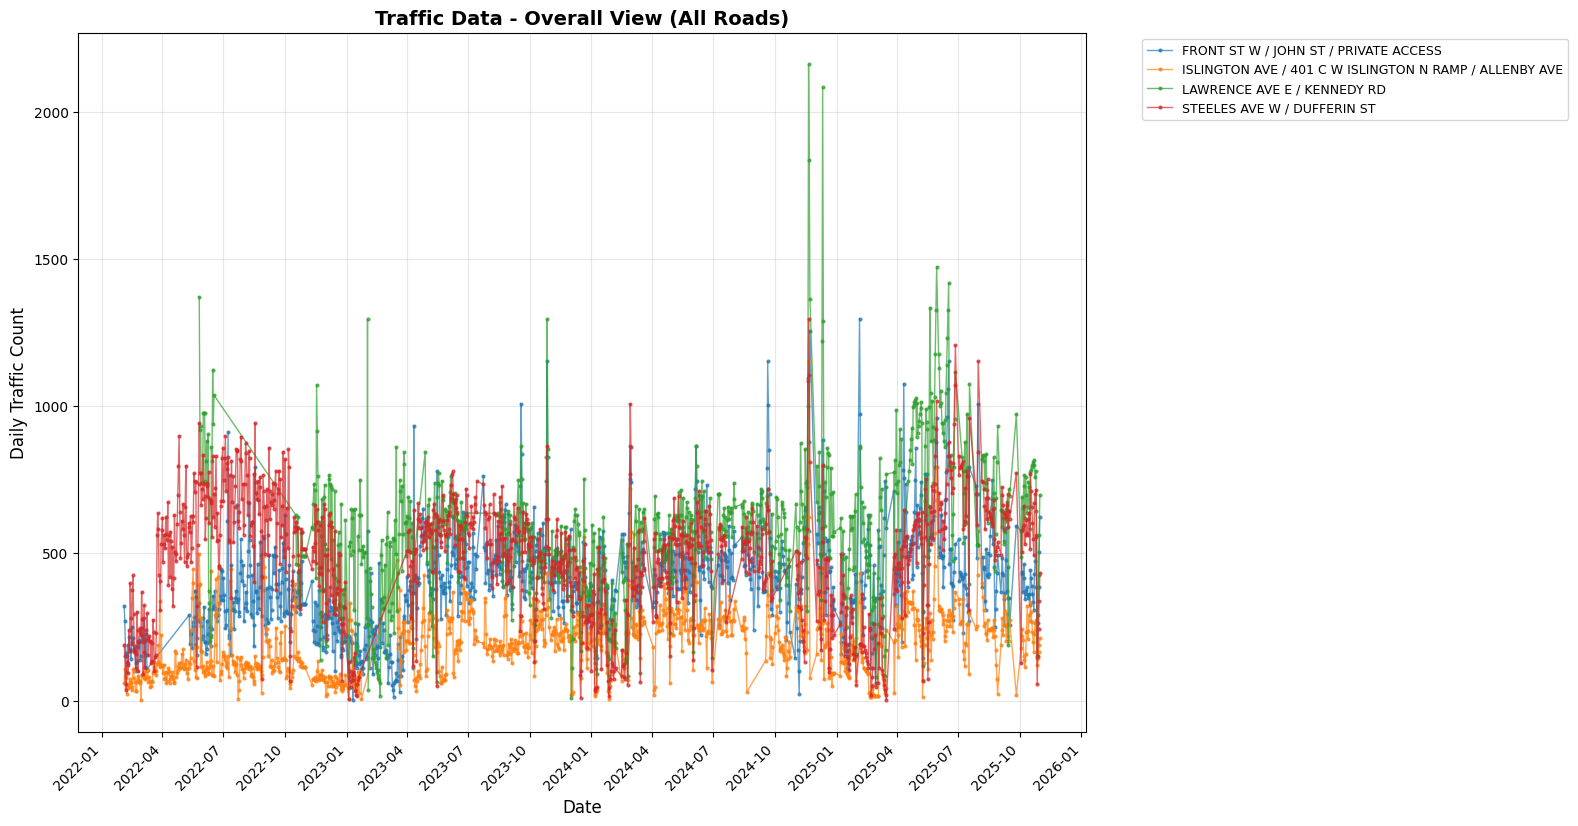

In [9]:
# PLOT 1: Overall View - All Traffic Data
plt.figure(figsize=(16, 8))

# Plot each road separately
for road in roads_keep:
    road_data = df_plot[df_plot['camera_road'] == road]
    plt.plot(road_data['date'], road_data['traffic'], marker='o', markersize=2, 
             linewidth=1, label=road, alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Traffic Count', fontsize=12)
plt.title('Traffic Data - Overall View (All Roads)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Format x-axis to show dates nicely
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

plt.show()

Date range: 2024-05-01 to 2024-05-20
Data points in this range: 80


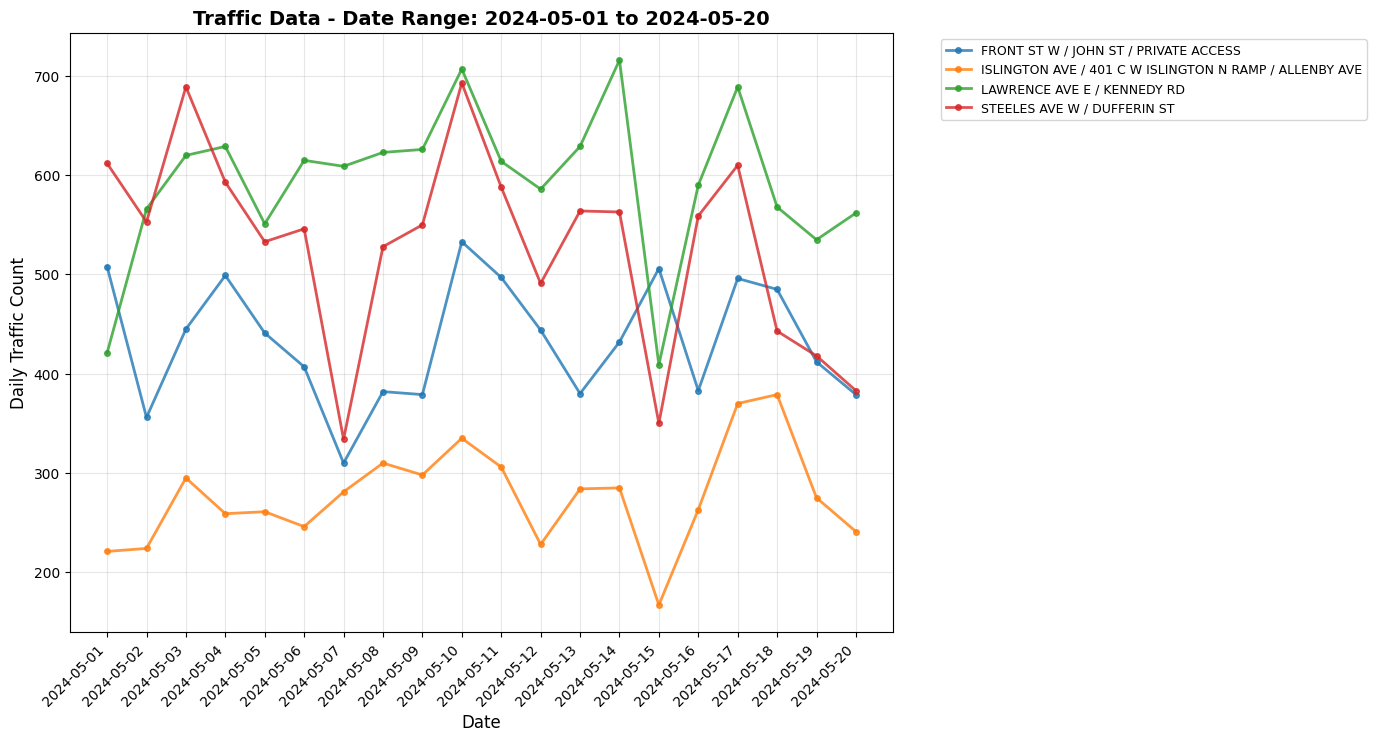

In [ ]:
# PLOT 2: Filtered View - Specific Date Range
# ========================================
# MODIFY THESE DATES TO VIEW DIFFERENT TIME PERIODS
# ========================================
start_date = '2024-05-01'  # <-- CHANGE THIS: Start date (YYYY-MM-DD)
end_date = '2024-05-20'    # <-- CHANGE THIS: End date (YYYY-MM-DD)
# ========================================

# Convert to datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter data by date range
df_plot_filtered = df_plot[(df_plot['date'] >= start_date) & (df_plot['date'] <= end_date)]

print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Data points in this range: {len(df_plot_filtered)}")

# Create the plot
plt.figure(figsize=(14, 7))

# Plot each road separately
for road in roads_keep:
    road_data = df_plot_filtered[df_plot_filtered['camera_road'] == road]
    if len(road_data) > 0:
        plt.plot(road_data['date'], road_data['traffic'], marker='o', markersize=4, 
                 linewidth=2, label=road, alpha=0.8)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Traffic Count', fontsize=12)
plt.title(f'Traffic Data - Date Range: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Format x-axis to show dates nicely
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())  # Show each day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.show()

# roads_keep = ["LAWRENCE AVE E / KENNEDY RD",                              # East
#               "STEELES AVE W / DUFFERIN ST",                              # North
#               "FRONT ST W / JOHN ST / PRIVATE ACCESS",                    # Downtown
#               "ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE",   # West (125 resources road)

In [11]:
# HELPER: View available date ranges for each road
print("Available date ranges by road:")
print("=" * 80)
for road in roads_keep:
    road_data = df_plot[df_plot['camera_road'] == road]
    if len(road_data) > 0:
        min_date = road_data['date'].min()
        max_date = road_data['date'].max()
        data_points = len(road_data)
        print(f"\n{road}")
        print(f"  Start: {min_date.strftime('%Y-%m-%d')}")
        print(f"  End:   {max_date.strftime('%Y-%m-%d')}")
        print(f"  Data points: {data_points}")

Available date ranges by road:

FRONT ST W / JOHN ST / PRIVATE ACCESS
  Start: 2022-02-03
  End:   2025-10-31
  Data points: 1158

ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE
  Start: 2022-02-03
  End:   2025-10-31
  Data points: 1144

LAWRENCE AVE E / KENNEDY RD
  Start: 2022-05-26
  End:   2025-10-31
  Data points: 886

STEELES AVE W / DUFFERIN ST
  Start: 2022-02-03
  End:   2025-10-31
  Data points: 1112
